   SL No. State/UT Name      District Name                       Mine Name  \
0       1   West Bengal  Paschim Bardhaman                Ningah Colliery    
1       2   West Bengal  Paschim Bardhaman         Jhanjhara Project Colly   
2       3   West Bengal  Paschim Bardhaman  MAOHUSUDANPUR 7 PIT &\nINCLINE   
3       4   West Bengal  Paschim Bardhaman                PARASCOLE(EAST)    
4       5   West Bengal  Paschim Bardhaman                PARASCOLE(WEST)    
5       6   West Bengal  Paschim Bardhaman                       Jambad UG   
6       7   West Bengal  Paschim Bardhaman                     Khas Kajora   
7       8   West Bengal  Paschim Bardhaman                  Central Kajora   
8       9   West Bengal  Paschim Bardhaman                      NABAKJORA    
9      10   West Bengal  Paschim Bardhaman                 Satgram Project   

  Coal/ Lignite Production (MT) (2019-2020) Coal Mine Owner Name  \
0                                      0,01                  ECL   
1    

C:\Users\MRUGANK KAPSE\AppData\Local\Temp\ipykernel_29208\1475874006.py:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['KNN', 'Decision Tree'], y=[acc_knn, acc_dt], palette='viridis')


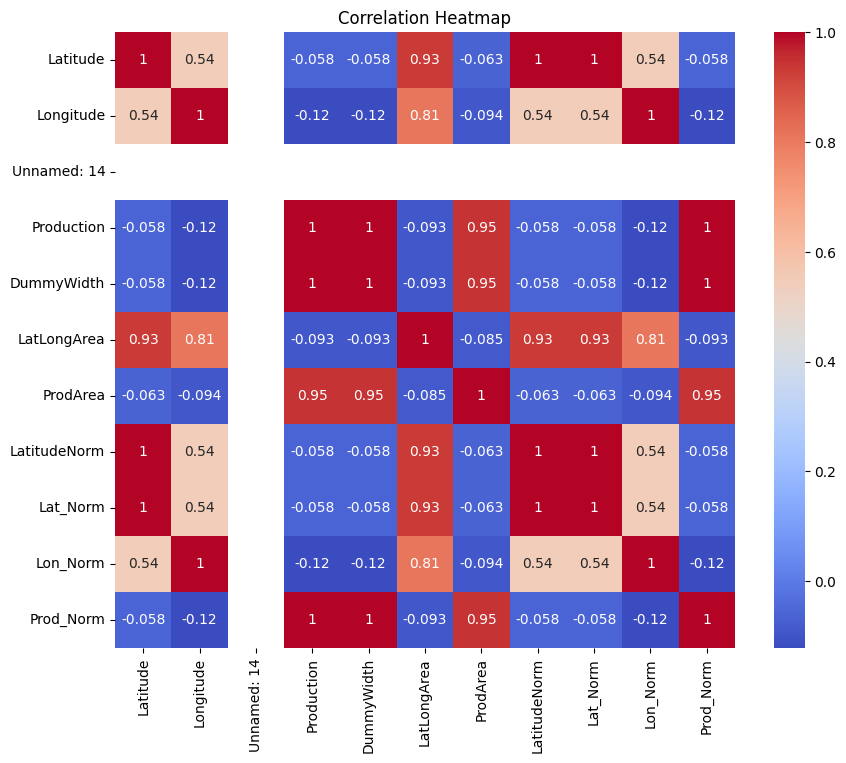

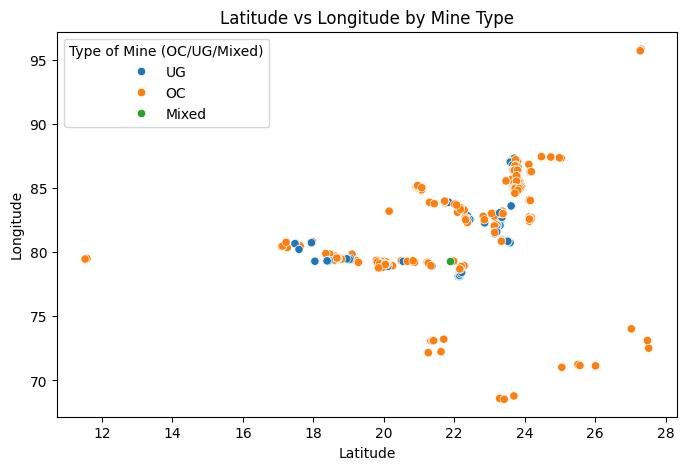

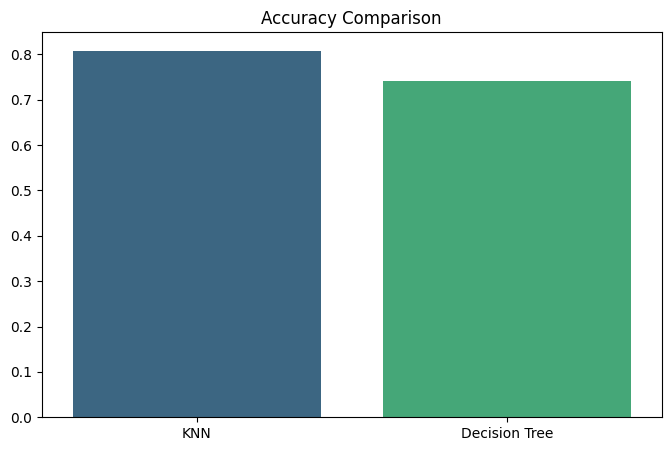

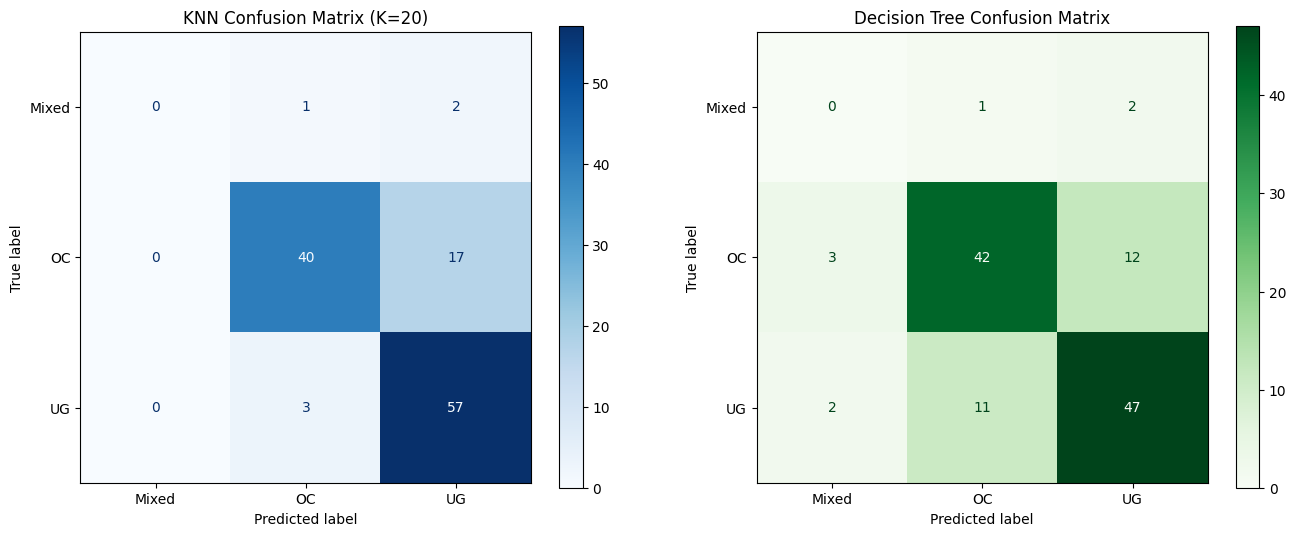

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
df = pd.read_csv(r"C:\Users\MRUGANK KAPSE\Downloads\Mines Datasheet-Tabelle 1.csv", sep=';')
df.columns = df.columns.str.strip()

def clean_numeric(val):
    if isinstance(val, str):
        val = val.replace(',', '.')
    try:
        return float(val)
    except:
        return np.nan

df['Latitude'] = df['Latitude'].apply(clean_numeric)
df['Longitude'] = df['Longitude'].apply(clean_numeric)
df['Production'] = df['Coal/ Lignite Production (MT) (2019-2020)'].apply(clean_numeric)
df['DummyWidth'] = df['Production'] * 0.1

print(df.head(10))
print(df.tail(10))
print(df.describe())
print(df.info())
print(df.shape)
print(df.isnull().sum())

df = df.drop_duplicates()
if 'SL No.' in df.columns:
    df.drop(columns=['SL No.'], inplace=True)

df['LatLongArea'] = df['Latitude'] * df['Longitude']
df['ProdArea'] = df['Production'] * df['DummyWidth']

lat_arr = df['Latitude'].to_numpy()
prod_arr = df['Production'].to_numpy()

print(np.mean(lat_arr))
print(np.std(prod_arr))
print(np.max(lat_arr))
print(np.min(prod_arr))

df['AreaSize'] = np.where(
    df['LatLongArea'] > df['LatLongArea'].mean(),
    'Large',
    'Small'
)

print(df.groupby('Type of Mine (OC/UG/Mixed)').mean(numeric_only=True))

print(
    df.groupby('Type of Mine (OC/UG/Mixed)').agg({
        'Latitude': ['mean', 'min', 'max'],
        'Production': ['mean', 'std']
    })
)

df_sorted = df.sort_values(by='Production', ascending=False)
print(df_sorted.head())

df['LatitudeNorm'] = (
    (df['Latitude'] - df['Latitude'].min()) /
    (df['Latitude'].max() - df['Latitude'].min())
)

large_area = df[df['LatLongArea'] > df['LatLongArea'].mean()]
print(large_area.head())

sample = df.sample(min(10, len(df)), random_state=1)
print(sample)

df_model = df.dropna(subset=['Latitude', 'Longitude', 'Production', 'Type of Mine (OC/UG/Mixed)']).copy()
Q1, Q3 = np.percentile(df_model['Production'], [25, 75])
IQR = Q3 - Q1
df_model = df_model[(df_model['Production'] >= (Q1 - 1.5 * IQR)) & (df_model['Production'] <= (Q3 + 1.5 * IQR))]

def normalize(col):
    return (col - np.min(col)) / (np.max(col) - np.min(col))

df_model['Lat_Norm'] = normalize(df_model['Latitude'])
df_model['Lon_Norm'] = normalize(df_model['Longitude'])
df_model['Prod_Norm'] = normalize(df_model['Production'])

X = df_model[['Lat_Norm', 'Lon_Norm', 'Prod_Norm']]
y = df_model['Type of Mine (OC/UG/Mixed)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

k_range = range(1, 21)
scores = []
for k in k_range:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp.fit(X_train, y_train)
    scores.append(metrics.accuracy_score(y_test, knn_temp.predict(X_test)))

optimal_k = k_range[np.argmax(scores)]
print(f"Optimal K: {optimal_k}")

knn_model = KNeighborsClassifier(n_neighbors=optimal_k)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)
acc_knn = metrics.accuracy_score(y_test, y_pred_knn)

dt_model = DecisionTreeClassifier(random_state=1)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
acc_dt = metrics.accuracy_score(y_test, y_pred_dt)

plt.figure(figsize=(10, 8))
sns.heatmap(df_model.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png')

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Latitude', y='Longitude', hue='Type of Mine (OC/UG/Mixed)')
plt.title("Latitude vs Longitude by Mine Type")
plt.savefig('scatter_plot.png')

plt.figure(figsize=(8, 5))
sns.barplot(x=['KNN', 'Decision Tree'], y=[acc_knn, acc_dt], palette='viridis')
plt.title('Accuracy Comparison')
plt.savefig('accuracy_comparison.png')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_knn, ax=ax[0], cmap='Blues')
ax[0].set_title(f'KNN Confusion Matrix (K={optimal_k})')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt, ax=ax[1], cmap='Greens')
ax[1].set_title('Decision Tree Confusion Matrix')
plt.savefig('confusion_matrices.png')